In [51]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import statistics
from scipy.spatial import distance

In [52]:
def load_initial(name):
    n_nodes = int(''.join(i for i in name if i.isdigit()))
    nodes = np.loadtxt(f"TSP/{name}.tsp.txt", skiprows = 6, max_rows = n_nodes)
    opt_tour = np.loadtxt(f"TSP/{name}.opt.tour.txt", skiprows = 5, max_rows = n_nodes)

    d_nodes = {}
    for node in nodes: 
        d_nodes[node[0]] = (node[1], node[2])

    return d_nodes, opt_tour

def plotnodes(nodes): 
    plt.figure(figsize = (9,9))

    for node, coordinates in nodes.items():
        plt.plot(coordinates[0], coordinates[1], 'ro')
        plt.annotate(int(node), (coordinates[0], coordinates[1]))

def plotedges(d_nodes, tour):
    x_route = [d_nodes[tour[0]][0]]
    y_route = [d_nodes[tour[0]][1]]

    for node in reversed(tour):
        x_route.append(d_nodes[node][0])
        y_route.append(d_nodes[node][1])

    plt.plot(x_route, y_route, color = 'grey')

def tour_length(d_nodes, tour):
    total_length = 0
    n_nodes = len(d_nodes)

    for i, node in enumerate(tour):
        x1 = d_nodes[node][0]
        y1 = d_nodes[node][1]
        x2 = d_nodes[tour[(i+1)%n_nodes]][0]
        y2 = d_nodes[tour[(i+1)%n_nodes]][1]
        
        total_length += math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    return total_length

length = 2586.7696475631606


<Figure size 1080x648 with 0 Axes>

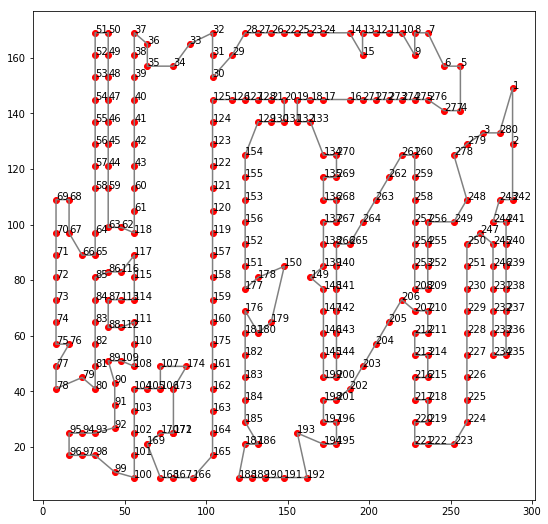

In [53]:
initial = load_initial("a280")
plt.figure(figsize = (15,9))
plotnodes(initial[0])
plotedges(initial[0], initial[1])
print('length = ' + str(tour_length(initial[0], initial[1])))

In [54]:
def make_distance_matrix(d_nodes):
    n_nodes = len(d_nodes)
    distance_matrix = np.zeros((n_nodes,n_nodes))
    
    for node1 in range(n_nodes):
        for node2 in range(n_nodes):
            x1 = d_nodes[node1+1][0]
            x2 = d_nodes[node2+1][0]
            y1 = d_nodes[node1+1][1]
            y2 = d_nodes[node2+1][1]

            distance_matrix[node1, node2] = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
    return distance_matrix
    
def matrix_tour_length(tour, distance_matrix):
    total_distance = 0

    for i in range(len(tour)): 
        total_distance += distance_matrix[int(tour[i] - 1), int(tour[(i+1)%len(tour)] - 1)]
        
    return total_distance

def make_random_route(n_nodes):
    l_nodes = np.arange(1,n_nodes+1)
    return list(np.random.permutation(l_nodes))

In [55]:
def lin2opt(old_tour, dist): 
    # apply lin 2 opt to tour
    
    # making sure there are at least two nodes between the two random nodes,
    # otherwise reversing the subtour has no effect
    while True:
        i, j = random.sample(range(len(old_tour)), 2)
        
        if (len(old_tour) + j - i)%len(old_tour) >= 3:
            break
    
    if i < j:
        new_tour = old_tour[:]
        new_tour[i + 1 : j] = new_tour[j - 1 : i : -1]
    else:
        # i > j is also a necessary scenario, but that means reversing the subtour
        # "around" the end and start of the tour list, which is more complicated
        new_tour = []
        
        extra = i + j - len(old_tour)
        if extra >= 0:
            new_tour += old_tour[extra : : -1]
        new_tour += old_tour[i + j : i : -1]
        new_tour += old_tour[j : i + 1]
        new_tour += old_tour[j - 1 : extra : -1]
        if extra < 0:
            if j > 0:
                new_tour += old_tour[j - 1 : : -1]
            new_tour += old_tour[ : len(new_tour) - 1 : -1]

    # calculate the difference in cost only for the changed edges, not the entire tour (saves a lot of time)
    cost_diff = ((dist[new_tour[i] - 1, new_tour[(i+1)%len(new_tour)] - 1] + dist[new_tour[j-1] - 1, new_tour[j] - 1])
                -(dist[old_tour[i] - 1, old_tour[(i+1)%len(old_tour)] - 1] + dist[old_tour[j-1] - 1, old_tour[j] - 1]))
    
    return new_tour, cost_diff

def move_node(old_tour, dist):
    new_tour = old_tour[:]
    
    i, j = random.sample(range(len(new_tour)), 2)
    new_tour.insert(i, new_tour.pop(j))

    # calculate the difference in cost only for the changed edges, not the entire tour (saves a lot of time)
    cost_offset = i < j
    cost_diff = ((dist[new_tour[i-1] - 1, new_tour[i] - 1] + dist[new_tour[i] - 1, new_tour[(i+1)%len(new_tour)] - 1] + dist[new_tour[j-1 + cost_offset] - 1, new_tour[(j + cost_offset)%len(new_tour)] - 1])
                -(dist[old_tour[j-1] - 1, old_tour[j] - 1] + dist[old_tour[j] - 1, old_tour[(j+1)%len(old_tour)] - 1] + dist[old_tour[i - cost_offset] - 1, old_tour[(i + 1 - cost_offset)%len(old_tour)] - 1]))

    return new_tour, cost_diff

In [59]:
def simulated_annealing(nodes, initial_tour, markov_chains, markov_length, initial_temp, cool_parameter, cool_method = "exponential", visual = True):
    tour = initial_tour
    temp = initial_temp

    distance_matrix = make_distance_matrix(nodes)

    # for plotting the costs per iteration
    costs = [matrix_tour_length(initial_tour, distance_matrix)]
    accepted = 0

    n = 0
    
    for i in range(markov_chains):
        if visual and n > 0:
            print('\r', f"{n} out of {markov_chains} {new_cost}", end='')

        if cool_method == "stdev":
            current_chain = []

        for _ in range(markov_length):
            if random.random() < 0.5:    
                new_tour, cost_diff = move_node(tour, distance_matrix)
            else:
                new_tour, cost_diff = lin2opt(tour, distance_matrix)

            # e^710 is too big to handle
            accept_prob = math.exp(min(709, -(cost_diff)/temp))
            new_cost = costs[-1] + cost_diff
            
            if cool_method == "stdev":
                current_chain.append(new_cost)

            if accept_prob >= 1 or random.random() <= accept_prob:
                tour = new_tour
                costs.append(new_cost)
                if n == 0:
                    accepted += 1
            else:
                costs.append(costs[-1])

        # uncomment this to stop the algorithm when the path hasn't changed in 100 Markov chains:
        # if len(costs) > 100 * markov_length and costs[-(100*markov_length)] == costs[-1]:
        #     break

        if cool_method == "exponential":
            temp *= cool_parameter
        elif cool_method == "stdev":
            sigma = statistics.stdev(current_chain)
            temp *= (1 + (math.log(1 + cool_parameter)*temp)/(3*sigma))**-1
        elif cool_method == "lecture":
            temp = initial_temp/math.log(n + cool_parameter)

        n += 1

    if visual:
        print(f" {100*accepted/markov_length:.3f}%", end='')
        plt.plot(range(len(costs)), costs)
        plt.xlabel("Metropolis steps")
        plt.ylabel("Route length")
        plt.show()

    return tour, costs

 499 out of 500 360.9044783667131 88.000% of 500 374.3915957851767

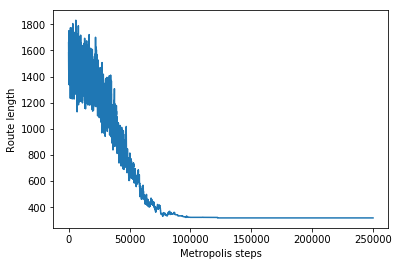

Length of found route: 431.953245361643
[13, 25, 14, 24, 43, 7, 23, 6, 27, 48, 8, 26, 31, 28, 3, 36, 35, 20, 29, 21, 34, 30, 9, 50, 16, 2, 22, 1, 32, 11, 46, 51, 12, 47, 18, 4, 17, 37, 5, 38, 49, 10, 39, 33, 45, 15, 44, 42, 19, 40, 41]


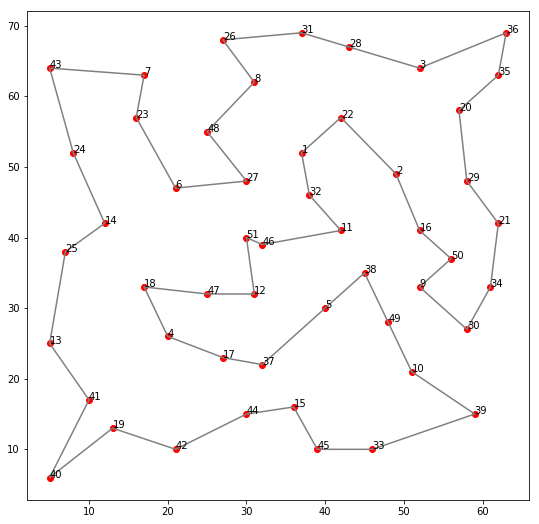

In [60]:
nodes = load_initial("eil51")[0]
annealed_tour = simulated_annealing(nodes, make_random_route(len(nodes)), 500, 500, 100, 0.975)[0]
plotnodes(nodes)
plotedges(nodes, annealed_tour)
print(f"Length of found route: {tour_length(nodes, annealed_tour)}")
print(annealed_tour)

 499 out of 500 3110.432216977383 96.200%

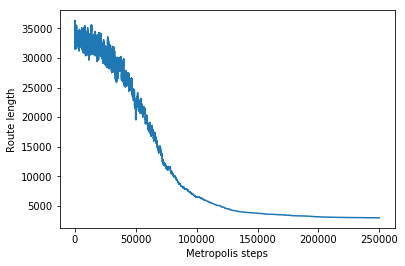

Length of found route: 2981.2192000330597


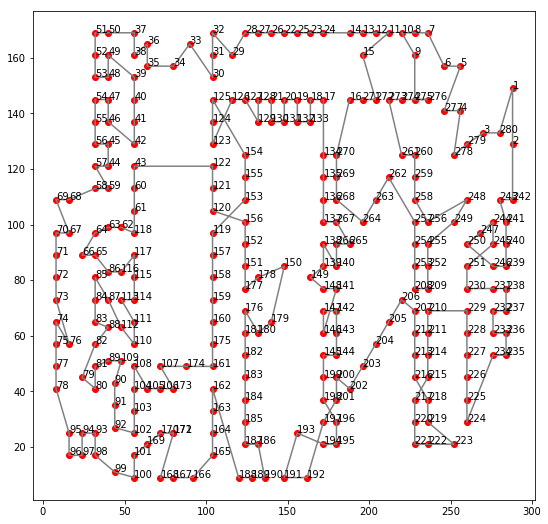

In [61]:
nodes = load_initial("a280")[0]
annealed_tour = simulated_annealing(nodes, make_random_route(len(nodes)), 500, 500, 1000, 0.975)[0]
plotnodes(nodes)
plotedges(nodes, annealed_tour)
print(f"Length of found route: {tour_length(nodes, annealed_tour)}")

In [11]:
# if we wanna save a tour, run this after generating it
with open('TSP_output/eil51_output4.txt', 'w') as f:
    f.write("NAME : ./TSPLIB/a280.tsp.optbc.tour\nCOMMENT : Optimal tour for a280.tsp\nTYPE : TOUR\nDIMENSION : 280\nTOUR_SECTION\n")
    for city in annealed_tour:
        f.write(str(city))
        f.write('\n')

In [30]:
TSP = "a280"
markov_chains = 50000
markov_length = 500
initial_temp = 500
cool_method = "exponential"

cr_first = 0.98
cr_last  = 0.999
cr_number = 10

repeats = 100000

# -------------------------------------

nodes = load_initial(TSP)[0]
best_tour = []

means = []
stdevs = []
# crs = [0.966] 
crs = np.linspace(cr_first, cr_last, cr_number)

with open(f"TSP_output/{TSP}_{markov_chains}_{markov_length}_{initial_temp}_{cool_method}.txt", "a") as myfile:
    lengths = []
    
    for i in range(repeats):
        for cr in crs:
            annealed_tour = simulated_annealing(nodes, make_random_route(len(nodes)), markov_chains, markov_length, initial_temp, cr, cool_method, False)
            length = tour_length(nodes, annealed_tour)
            lengths.append(length)

            myfile.write(f"{cr}, {length}\n")

            print('\r', f"{cr, i}", end='')

            if length == min(lengths):
                best_tour = annealed_tour

        # means.append(np.mean(lengths))
        # stdevs.append(statistics.stdev(lengths))


# plt.plot(crs, means)
# plt.fill_between(crs, np.array(means)-np.array(stdevs), np.array(means)+np.array(stdevs), alpha=.2)
# plt.show()


plotnodes(nodes)
plotedges(nodes, best_tour)
print(f"\nLength of found route: {tour_length(nodes, best_tour)}")

 (0.982111111111111, 4))

KeyboardInterrupt: 

1 0.0 203 2859.3482007534058
2 0.095 200 2856.3897447100403
3 0.19 200 2853.4135497224365
4 0.28500000000000003 200 2853.6175525015406
5 0.38 200 2847.78657513143
6 0.475 200 2857.394689762967
7 0.5700000000000001 200 2848.13657465974
8 0.665 200 2851.915852369263
9 0.76 200 2849.395074988191
10 0.855 200 2857.2097983183503
11 0.9 100 2855.625689138413
12 0.91 100 2852.292693542025
13 0.92 100 2862.765128137819
14 0.93 100 2858.7058676429842
15 0.9400000000000001 100 2851.846570001674
16 0.95 300 2849.3750674223734
17 0.96 100 2840.140638216357
18 0.97 100 2844.227872255718
19 0.98 112 2840.559705536914
20 0.982111111111111 12 2843.6487549059693
22 0.9863333333333333 10 2819.031076661055
24 0.99 100 2833.2040059374635
25 0.9905555555555555 10 2814.9079059886417
26 0.9926666666666667 10 2823.8740855224105
27 0.9947777777777778 10 2790.9477786721336
28 0.9968888888888889 10 2757.813007121872
29 0.999 10 2696.1676409319102


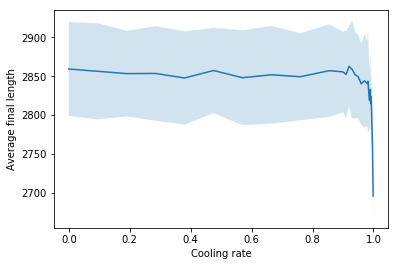

In [37]:
TSP = "a280"
markov_chains = 50000
markov_length = 500
initial_temp = 500
cool_method = "exponential"
addendum = ""


data = {}

with open(f"TSP_output/{TSP}_{markov_chains}_{markov_length}_{initial_temp}_{cool_method}{addendum}.txt") as f:
# with open('TSP_output/a280_500_500_500_stdev_new.txt') as f:
    temp = f.read().splitlines()

    for line in temp:
        split_line = line.split(", ")

        if split_line[0] not in data:
            data[split_line[0]] = []

        data[split_line[0]].append(float(split_line[1]))

crs = []
means = []
stdevs = []
n = 1

data = dict((float(key), value) for (key, value) in data.items())

for key, results in sorted(data.items()):
    if float(key) < 1:
        crs.append(float(key))
        means.append(np.mean(results))
        stdevs.append(statistics.stdev(results))
        print(n, key, len(results), means[-1])

    n += 1

plt.plot(crs, means)
plt.fill_between(crs, np.array(means)-np.array(stdevs), np.array(means)+np.array(stdevs), alpha=.2)
# plt.ylim(2825, 3025)
# plt.ylim(2725, 2925)
plt.xlabel("Cooling rate")
plt.ylabel("Average final length")
plt.savefig(f"TSP_output/{TSP}_{markov_chains}_{markov_length}_{initial_temp}_{cool_method}{addendum}.jpeg", edgecolor='black', dpi=400, facecolor='white', transparent=True)

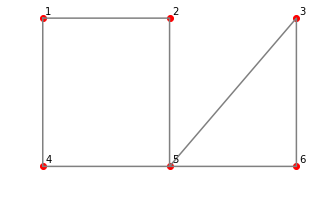

In [73]:
nodes = {1: (0,1), 
         2: (1,1), 
         3: (2,1), 
         4: (0,0), 
         5: (1,0), 
         6: (2,0), }

path = [1, 2, 5, 3, 6, 4]

plotnodes(nodes)
plotedges(nodes, path)
plt.savefig("movenode.jpeg", edgecolor='black', dpi=400, facecolor='white', transparent=True)

In [ ]:
def SA_simulations(nodes, markov_length, iterations, initial_temp, cool_rate, n):
    # determine number of markov chains: total number of iterations should remain the same
    # so if markov chain length is increased, number of markov chains should be lower.

    # Additionally, the cooling rate should be increased so the final temperature is still reached.
    markov_chains = int(iterations/markov_length)
    length_besttour = 10e100

    tours = []
    # save costs per iteration in a markov chain. dictionary should be one longer than range(iterations)
    # because the random initial tour is also saved in the costs list. 
    d_costs = {}
    for i in range(iterations + 1):
        d_costs[i] = []
    
    for i in range(n):
        print(i) 
        
        tour, costs = simulated_annealing(nodes, make_random_route(len(nodes)), markov_chains, markov_length, initial_temp, cool_rate)
        tours.append(tour)
        for j, elem in enumerate(costs):
            d_costs[j].append(elem)
            if elem < length_besttour: 
                length_besttour = elem
                best_tour = tour
    
    return tours, d_costs, best_tour, length_besttour

nodes = load_initial("a280")[0]
tours, d_costs, best_tour, length_besttour = SA_simulations(nodes, 500, 500000, 1000, 0.975, 10)

0
 999 out of 1000378 out of 10001
 999 out of 1000229 out of 10002
 999 out of 1000620 out of 10003
 999 out of 10004
 999 out of 10005
 999 out of 10006
 999 out of 10007
 999 out of 10008
 999 out of 1000476 out of 10009
 999 out of 1000

TypeError: 'list' object cannot be interpreted as an integer

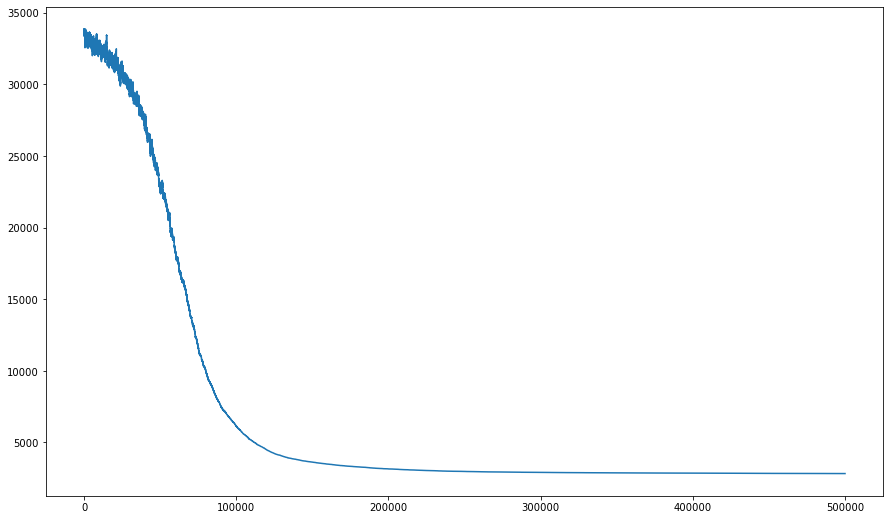

In [ ]:
costs_lower = []
costs_upper = []
costs_mean = []
costs_std = []

for key in d_costs:
    costs_lower.append(np.mean(d_costs[key] - np.std(d_costs[key])))
    costs_upper.append(np.mean(d_costs[key] + np.std(d_costs[key])))
    costs_mean.append(np.mean(d_costs[key]))
    costs_std.append(np.std(d_costs[key]))

plt.figure(figsize = (15,9))
plt.plot(range(len(costs_mean)), costs_mean, color = 'tab:blue')
plt.fill_between((len(costs_mean), costs_lower, costs_upper), color = 'tab:blue', alpha = 0.2)
plt.show()

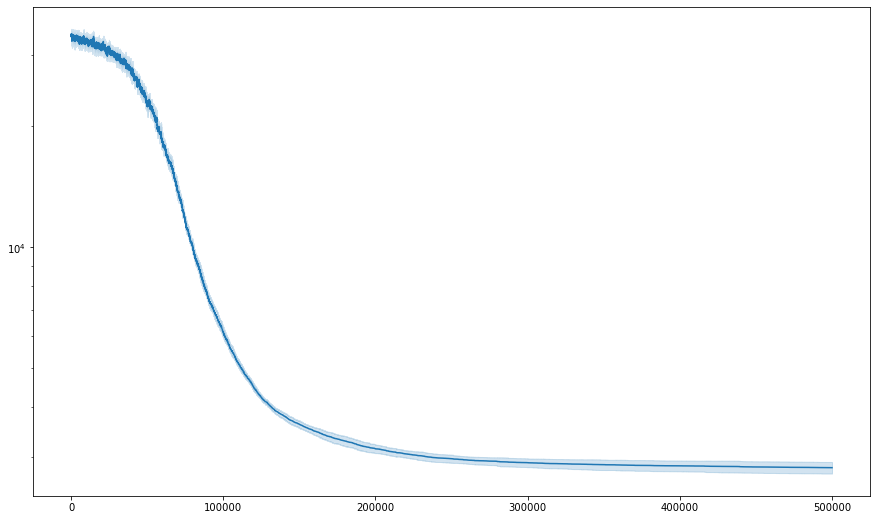

In [ ]:
plt.figure(figsize = (15,9))
plt.plot(range(len(costs_mean)), costs_mean, '')
plt.fill_between(range(len(costs_mean)), costs_lower, costs_upper, color = 'tab:blue', alpha = 0.2)
plt.yscale('log')
plt.show()